# Classification part

In the previous step, we have built and tested various autoencoders.
Each one represents an image in a number of coding variables, which is (in most of the cases) relatively small compared to 
the number of pixels. The question remains whether these variables contain semantic information, hence can be used to classify 
images into distinct classes.

In this part of the project, a simple logistic regression (classification task) is taking place. We use two of the autoencoders built in the previous steps; we take the output of the encoder (the coding variables) of each
auto-encoder and use it as input to a fully connected layer. 

We train two networks. 
* First, we simply take the encoding part of the auto-encoder, freeze these layers and add a fully-connected layer at the end (fine-tuning). 
* Second, we use the same network architecture but train all parameters from scratch.

Various cost functions, optimizers and activation functions are tested in each case.
 
**Loss Functions used**: 
* **Categorical Cross Entropy**: Categorical cross entropy is a loss function that is used for single label categorization. This is when only one category is applicable for each data point. In other words, an example can belong to one class only (multi-class classification). It is perfectly combined with the Softmax activation function. 
* **Binary Cross Entropy**: Also called Sigmoid Cross-Entropy loss. It is a Sigmoid activation plus a Cross-Entropy loss. Perfectly used for multi-label classification tasks, where many labels can be assigned to each object and it is combined with the Sigmoid activation functions for better results.   

Since the provided data for this classification task are multi-labeled data, we expect the use of the binary cross entropy loss function, combined with the sigmoid activation function, to provide better results for the classifier than that of the categorical cross entropy.

We have to mention, also, that for the auto-encoders used, fine-tuning proved a better approach, because in a different case the model overfitted almost immediately. In general, the network here could easily get overfitted, even for small iterations and as result there were times that enforced interruption was used.

#### Download the data

In [0]:
!wget -cq http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar
!tar -xvf VOCtrainval_11-May-2009.tar

#### Import packages

In [2]:
from lxml import etree
import numpy as np
import os
from skimage import io
from skimage.transform import resize
from matplotlib import pyplot as plt
import cv2
import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from keras import regularizers
from keras.optimizers import RMSprop
from keras.utils.vis_utils import plot_model
from sklearn.metrics import mean_squared_error
from keras.callbacks import ModelCheckpoint
from keras.layers import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation, Dense

Using TensorFlow backend.


In [0]:
!pip install livelossplot
from livelossplot import PlotLossesKeras

#### Build the data in the appropriate format

In [0]:
# set parameters before running this script
filter = ['aeroplane', 'car', 'chair', 'dog', 'bird']       # select class, this default should yield 1489 training and 1470 validation images
voc_root_folder = "./VOCdevkit/"  
image_size = 208   # image size that we use for our network (input images are resampled to this size)

In [0]:
# step1 - build list of filtered filenames
annotation_folder = os.path.join(voc_root_folder, "VOC2009/Annotations/")
annotation_files = os.listdir(annotation_folder)

In [0]:
# step2 - build (x,y) for TRAIN/VAL (classification)
classes_folder = os.path.join(voc_root_folder, "VOC2009/ImageSets/Main/") #path in order to reach Main file
classes_files = os.listdir(classes_folder)

In [0]:
train_files = [os.path.join(classes_folder, c_f) for filt in filter for c_f in classes_files if filt in c_f and '_train.txt' in c_f]
val_files = [os.path.join(classes_folder, c_f) for filt in filter for c_f in classes_files if filt in c_f and '_val.txt' in c_f]

In [0]:
def build_classification_dataset(list_of_files):
    """ build training or validation set

    :param list_of_files: list of filenames to build trainset with
    :return: tuple with x np.ndarray of shape (n_images, image_size, image_size, 3) and  y np.ndarray of shape (n_images, n_classes)
    """
    temp = []
    train_labels = []
    for f_cf in list_of_files:
        with open(f_cf) as file:
            lines = file.read().splitlines()
            temp.append([line.split()[0] for line in lines if int(line.split()[-1]) == 1])
            label_id = [f_ind for f_ind, filt in enumerate(filter) if filt in f_cf][0]
            train_labels.append(len(temp[-1]) * [label_id])
    train_filter = [item for l in temp for item in l]

    image_folder = os.path.join(voc_root_folder, "VOC2009/JPEGImages/")
    image_filenames = [os.path.join(image_folder, file) for f in train_filter for file in os.listdir(image_folder) if
                       f in file]
    x = np.array([resize(io.imread(img_f), (image_size, image_size, 3)) for img_f in image_filenames]).astype(
        'float32')
    # changed y to an array of shape (num_examples, num_classes) with 0 if class is not present and 1 if class is present
    y_temp = []
    for tf in train_filter:
        y_temp.append([1 if tf in l else 0 for l in temp])
    y = np.array(y_temp)

    return x, y

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718664 bytes but only got 0. Skipping tag 257
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 31197188 bytes but only got 0. Skipping tag 1029
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20971520 bytes but only got 0. Skipping tag 2
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 23592960 bytes but only got 0. Skipping tag 2
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecti

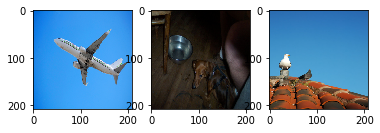

In [9]:
x_train, y_train = build_classification_dataset(train_files) #y_train is in the form of [[1 0 0 0 0] [1 0 0 0 0] ... ]
x_val, y_val = build_classification_dataset(val_files)

# Display some images
plt.subplot(1,3,1)
plt.imshow(x_train[0])
plt.subplot(1,3,2)
plt.imshow(x_val[987])
plt.subplot(1,3,3)
plt.imshow(x_val[1230])
plt.show()

# **First Autoencoder: Coding Variables: 692224**

In [0]:
input_img = Input(shape = (208, 208, 3))

def auto_encode(input_img):

    conv1 = Conv2D(32, (3, 3), padding='same')(input_img)
    conv1 = LeakyReLU(alpha=0.01)(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), padding='same')(conv1)
    conv1 = LeakyReLU(alpha=0.01)(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) 
    conv2 = Conv2D(64, (3, 3), padding='same')(pool1)
    conv2 = LeakyReLU(alpha=0.01)(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), padding='same')(conv2)
    conv2 = LeakyReLU(alpha=0.01)(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) 
    conv3 = Conv2D(128, (3, 3), padding='same')(pool2)
    conv3 = LeakyReLU(alpha=0.01)(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), padding='same')(conv3)
    conv3 = LeakyReLU(alpha=0.01)(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), padding='same')(conv3)
    conv4 = LeakyReLU(alpha=0.01)(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), padding='same')(conv4)
    conv4 = LeakyReLU(alpha=0.01)(conv4)
    encoder = BatchNormalization()(conv4)
    
    # Flatten encoding for visualization    
    #flat = Flatten()(encoder)
    #resh = Reshape((52,52,256))(flat)
   
    #decoder
    #conv5 = Conv2D(128, (3, 3), padding='same')(resh)
    conv5 = Conv2D(128, (3, 3), padding='same')(encoder)
    conv5=LeakyReLU(alpha=0.01)(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), padding='same')(conv5)
    conv5=LeakyReLU(alpha=0.01)(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3, 3), padding='same')(conv5)
    conv6=LeakyReLU(alpha=0.01)(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), padding='same')(conv6)
    conv6=LeakyReLU(alpha=0.01)(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6)
    conv7 = Conv2D(32, (3, 3), padding='same')(up1)
    conv7=LeakyReLU(alpha=0.01)(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), padding='same')(conv7)
    conv7=LeakyReLU(alpha=0.01)(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up2) 
    return decoded

W0831 20:47:55.762512 140523827689344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0831 20:47:55.776410 140523827689344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



In [0]:
#Build the model
autoencoder = Model(input_img, auto_encode(input_img)) 

autoencoder.summary()

W0831 20:47:59.519607 140523827689344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0831 20:47:59.554083 140523827689344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0831 20:47:59.555030 140523827689344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:197: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0831 20:48:00.148607 140523827689344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2041: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0831 20:48:00.282718 1405

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 208, 208, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 208, 208, 32)      896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 208, 208, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 208, 208, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 208, 208, 32)      9248      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 208, 208, 32)      0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 208, 208, 32)      128 

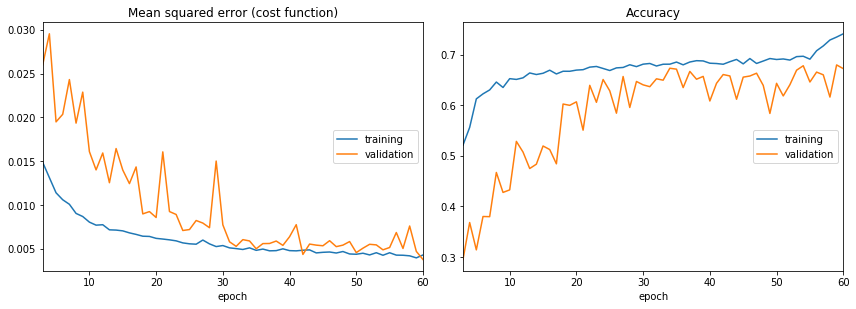

Mean squared error (cost function):
training   (min:    0.004, max:    0.033, cur:    0.004)
validation (min:    0.004, max:    0.038, cur:    0.004)

Accuracy:
training   (min:    0.430, max:    0.741, cur:    0.741)
validation (min:    0.295, max:    0.679, cur:    0.672)


In [0]:
#Compile the model and train
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop(), metrics=['accuracy'])
autoencoder_train = autoencoder.fit(x_train, x_train, epochs=60, batch_size=64, verbose=1, validation_data=(x_val, x_val), callbacks=[PlotLossesKeras()])

In [0]:
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('batch_normalization_8').output)
#encoder.summary()

(-0.5, 207.5, 207.5, -0.5)

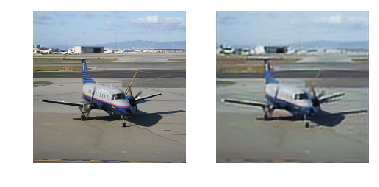

In [0]:
#autoencoder output in test set
reconstructed_image = autoencoder.predict(x_val)

# Display an image from the original test set
plt.subplot(121)
plt.imshow(x_val[90])
plt.axis('off')

# Display the reconstructed version of this image
plt.subplot(122)
plt.imshow(reconstructed_image[90])
plt.axis('off')

## Classifier (freeze the encoder layers): 

**First Case:**

- loss: categorical_crossentropy
- activation: softmax
- optimizer: adam

In [0]:
#Build encoder model
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('batch_normalization_8').output)

#Freeze the encoder layers
for layer in encoder.layers:
    layer.trainable = False

encoder_output_flatten = Flatten()(encoder.output)
dense = Dense(5, activation='softmax')(encoder_output_flatten)
classifier_freeze = Model(inputs=input_img, outputs=dense)

classifier_freeze.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 208, 208, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 208, 208, 32)      896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 208, 208, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 208, 208, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 208, 208, 32)      9248      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 208, 208, 32)      0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 208, 208, 32)      128 

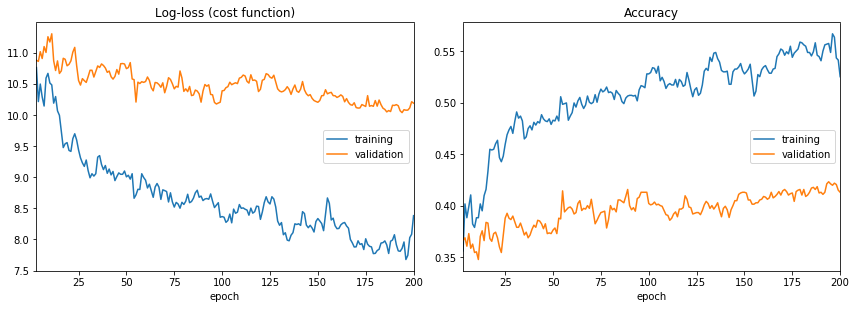

Log-loss (cost function):
training   (min:    7.677, max:   10.988, cur:    8.381)
validation (min:   10.036, max:   11.302, cur:   10.189)

Accuracy:
training   (min:    0.318, max:    0.567, cur:    0.525)
validation (min:    0.339, max:    0.423, cur:    0.413)


In [0]:
#Compile and train
classifier_freeze.compile(loss= "categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
classifier_freeze_train = classifier_freeze.fit(x_train, y_train, epochs=200, batch_size=64,verbose=1,validation_data=(x_val, y_val), callbacks=[PlotLossesKeras()])

In [0]:
# Model Evaluation on the Test Set
test_evaluation = classifier_freeze.evaluate(x_val, y_val, verbose=0)
print('Test loss:', test_evaluation[0])
print('Test accuracy:', test_evaluation[1])

Test loss: 10.188554375836638
Test accuracy: 0.41292517014912195


In [0]:
# Predict Labels
predicted_classes = classifier_freeze.predict(x_val)
#print(predicted_classes)

In [0]:
#Transform the classes to numbers 1-5
predicted_classes_num = np.argmax(np.round(predicted_classes),axis=1)
test_classes_num = np.argmax(np.round(y_val),axis=1)

Found 607 correct labels


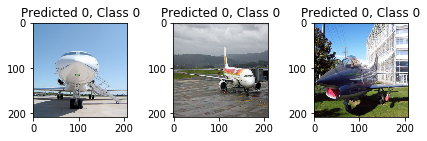

In [0]:
#Plot images that have been classified correctly
correct = np.where(predicted_classes_num==test_classes_num)[0]
print("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[:3]):
    plt.subplot(1,3,i+1)
    plt.imshow(x_val[correct])
    plt.title("Predicted {}, Class {}".format(predicted_classes_num[correct], test_classes_num[correct]))
    plt.tight_layout()

Found 863 incorrect labels


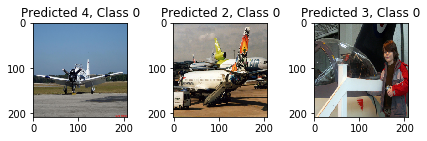

In [0]:
#Plot images that have not been classified correctly
incorrect = np.where(predicted_classes_num!=test_classes_num)[0]
print("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[:3]):
    plt.subplot(1,3,i+1)
    plt.imshow(x_val[incorrect])
    plt.title("Predicted {}, Class {}".format(predicted_classes_num[incorrect], test_classes_num[incorrect]))
    plt.tight_layout()

**Second Case:**

- loss: categorical_crossentropy
- activation: softmax
- optimizer: RMSprop()

In [0]:
#Build the model
encoder_2 = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('batch_normalization_8').output)

#Freeze the encoder layers
for layer in encoder_2.layers:
    layer.trainable = False

encoder_output_flatten_2 = Flatten()(encoder_2.output)
dense_2 = Dense(5, activation='softmax')(encoder_output_flatten_2)
classifier_freeze_2 = Model(inputs=input_img, outputs=dense_2)

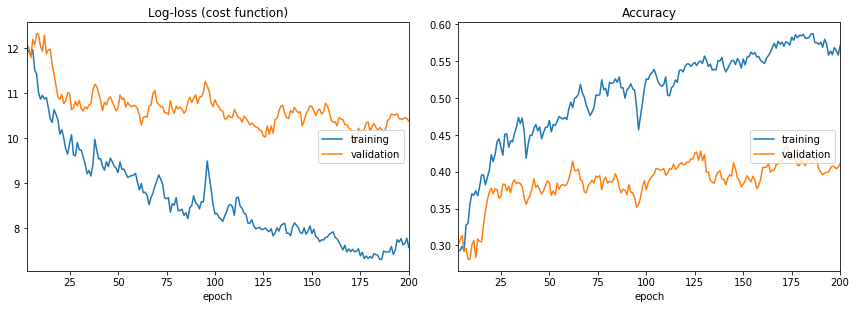

Log-loss (cost function):
training   (min:    7.296, max:   11.964, cur:    7.562)
validation (min:    9.916, max:   12.315, cur:   10.372)

Accuracy:
training   (min:    0.292, max:    0.587, cur:    0.571)
validation (min:    0.281, max:    0.433, cur:    0.411)


In [0]:
#Compile and train
classifier_freeze_2.compile(loss= "categorical_crossentropy", optimizer="rmsprop", metrics=['accuracy'])
classifier_freeze_train_2 = classifier_freeze_2.fit(x_train, y_train, epochs=200, batch_size=64,verbose=1,validation_data=(x_val, y_val), callbacks=[PlotLossesKeras()])

In [0]:
# Model Evaluation on the Test Set
test_evaluation_2 = classifier_freeze_2.evaluate(x_val, y_val, verbose=0)
print('Test loss:', test_evaluation_2[0])
print('Test accuracy:', test_evaluation_2[1])

Test loss: 10.371968466570587
Test accuracy: 0.4108843539442335


In [0]:
# Predict Labels
predicted_classes_2 = classifier_freeze_2.predict(x_val)

#Transform the classes to numbers 0-4
predicted_classes_num_2 = np.argmax(np.round(predicted_classes_2),axis=1)
test_classes_num_2 = np.argmax(np.round(y_val),axis=1)

#Calculate correct and incorrent classifications
correct2 = np.where(predicted_classes_num_2 == test_classes_num_2)[0]
incorrect2 = np.where(predicted_classes_num_2 != test_classes_num_2)[0]

print("Found %d correct labels" % len(correct2))
print("Found %d incorrect labels" % len(incorrect2))

Found 604 correct labels
Found 866 incorrect labels


**Third Case:**

- loss: binary_crossentropy
- activation: sigmoid
- optimizer: adam

In [0]:
#Build the model
encoder_3 = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('batch_normalization_8').output)

#Freeze the encoder layers
for layer in encoder_3.layers:
    layer.trainable = False

encoder_output_flatten_3 = Flatten()(encoder_3.output)
dense_3 = Dense(5, activation='sigmoid')(encoder_output_flatten_3)
classifier_freeze_3 = Model(inputs=input_img, outputs=dense_3)

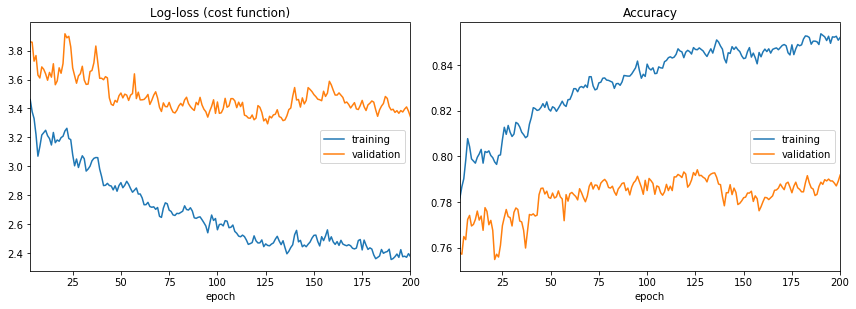

Log-loss (cost function):
training   (min:    2.354, max:    3.620, cur:    2.375)
validation (min:    3.294, max:    3.940, cur:    3.343)

Accuracy:
training   (min:    0.750, max:    0.854, cur:    0.852)
validation (min:    0.752, max:    0.794, cur:    0.792)


In [0]:
#Compile and train
classifier_freeze_3.compile(loss= "binary_crossentropy", optimizer="adam", metrics=['accuracy'])
classifier_freeze_train_3 = classifier_freeze_3.fit(x_train, y_train, epochs=200, batch_size=64,verbose=1,validation_data=(x_val, y_val), callbacks=[PlotLossesKeras()])

In [0]:
# Model Evaluation on the Test Set
test_evaluation_3 = classifier_freeze_3.evaluate(x_val, y_val, verbose=0)
print('Test loss:', test_evaluation_3[0])
print('Test accuracy:', test_evaluation_3[1])

Test loss: 3.342711267017183
Test accuracy: 0.7918367479123226


**Fourth Case:**

- loss: binary_crossentropy
- activation: sigmoid
- optimizer: RMSprop()

In [0]:
#Build the model
encoder_4 = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('batch_normalization_8').output)

#Freeze the encoder layers
for layer in encoder_4.layers:
    layer.trainable = False

encoder_output_flatten_4 = Flatten()(encoder_4.output)
dense_4 = Dense(5, activation='sigmoid')(encoder_output_flatten_4)
classifier_freeze_4 = Model(inputs=input_img, outputs=dense_4)

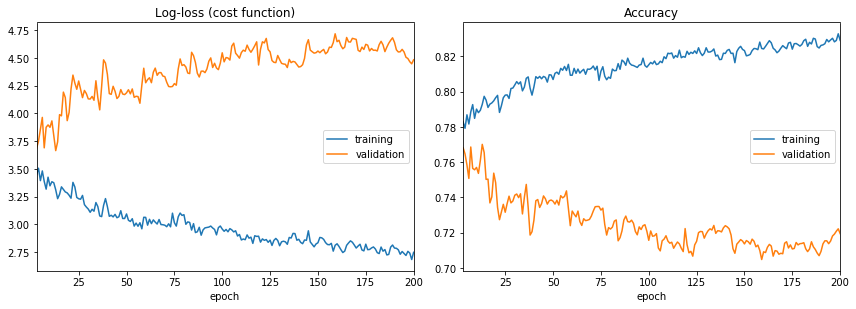

Log-loss (cost function):
training   (min:    2.684, max:    3.844, cur:    2.749)
validation (min:    3.665, max:    4.717, cur:    4.483)

Accuracy:
training   (min:    0.737, max:    0.833, cur:    0.829)
validation (min:    0.705, max:    0.770, cur:    0.719)


In [0]:
#Compile and train
classifier_freeze_4.compile(loss= "binary_crossentropy", optimizer= "rmsprop", metrics=['accuracy'])
classifier_freeze_train_4 = classifier_freeze_4.fit(x_train, y_train, epochs=200, batch_size=64,verbose=1,validation_data=(x_val, y_val), callbacks=[PlotLossesKeras()])

#### In this scenario, we notice that instead of decreasing the validation loss, it increases from the beginning.

In [0]:
# Model Evaluation on the Test Set
test_evaluation_4 = classifier_freeze_4.evaluate(x_val, y_val, verbose=0)
print('Test loss:', test_evaluation_4[0])
print('Test accuracy:', test_evaluation_4[1])

Test loss: 4.483366808599356
Test accuracy: 0.7194557867893556


## **Classifier (Retrain encoder layers)**

**First Case:**

- loss: categorical_crossentropy
- activation: softmax
- optimizer: adam

In [0]:
#Build the model
encoder_5 = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('batch_normalization_8').output)

#Do not freeze the encoder layers
for layer in encoder_5.layers:
    layer.trainable = True
    #Randomy initialize each parameter at start of training
    #if hasattr(layer, 'kernel_initializer'):
    #        layer.kernel_initializer = 'random_uniform'  #random_normal
    #        layer.bias_initializer = 'zeros'

encoder_output_flatten_5 = Flatten()(encoder_5.output)
dense_5 = Dense(5, activation='softmax')(encoder_output_flatten_5)
classifier_non_frozen_5 = Model(inputs=input_img, outputs=dense_5)

In [3]:
#Compile and train
#It started overfitting, so stopped it earlier
#Stopped it manually. Keras offers the EarlyStopping function as well, which by monitoring the validation loss can stop automatically the training process to avoid overfitting.
classifier_non_frozen_5.compile(loss= "categorical_crossentropy", optimizer= "adam", metrics=['accuracy'])
classifier_non_frozen_train_5 = classifier_non_frozen_5.fit(x_train, y_train, epochs=100, batch_size=64,verbose=1,validation_data=(x_val, y_val), callbacks=[PlotLossesKeras()])

In [0]:
# Model Evaluation on the Test Set
test_evaluation_5 = classifier_non_frozen_5.evaluate(x_val, y_val, verbose=0)
print('Test loss:', test_evaluation_5[0])
print('Test accuracy:', test_evaluation_5[1])

Test loss: 13.651040185227686
Test accuracy: 0.20884353765825026


In [0]:
# Predict Labels
predicted_classes_5 = classifier_non_frozen_5.predict(x_val)

#Transform the classes to numbers 0-4
predicted_classes_num_5 = np.argmax(np.round(predicted_classes_5),axis=1)
test_classes_num_5 = np.argmax(np.round(y_val),axis=1)

#Calculate correct and incorrent classifications
correct5 = np.where(predicted_classes_num_5 == test_classes_num_5)[0]
incorrect5 = np.where(predicted_classes_num_5 != test_classes_num_5)[0]

print("Found %d correct labels" % len(correct5))
print("Found %d incorrect labels" % len(incorrect5))

Found 307 correct labels
Found 1163 incorrect labels


**Second Case:**

- loss: binary_crossentropy
- activation: sigmoid
- optimizer: adam

***Stopped earlier because it would overfit***

In [0]:
#Build the model
encoder_6 = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('batch_normalization_8').output)

#Do not freeze the encoder layers
for layer in encoder_6.layers:
    layer.trainable = True
    #Randomy initialize each parameter at start of training
    #if hasattr(layer, 'kernel_initializer'):
    #        layer.kernel_initializer = 'random_uniform'  #random_normal
    #        layer.bias_initializer = 'zeros'

encoder_output_flatten_6 = Flatten()(encoder_6.output)
dense_6 = Dense(5, activation='sigmoid')(encoder_output_flatten_6)
classifier_non_frozen_6 = Model(inputs=input_img, outputs=dense_6)

In [2]:
#Compile and train
#Getting overffiting after almost 22 epochs
classifier_non_frozen_6.compile(loss= "binary_crossentropy", optimizer= "adam", metrics=['accuracy'])
classifier_non_frozen_train_6 = classifier_non_frozen_6.fit(x_train, y_train, epochs=100, batch_size=64,verbose=1,validation_data=(x_val, y_val), callbacks=[PlotLossesKeras()])

In [0]:
# Model Evaluation on the Test Set
test_evaluation_6 = classifier_non_frozen_6.evaluate(x_val, y_val, verbose=0)
print('Test loss:', test_evaluation_6[0])
print('Test accuracy:', test_evaluation_6[1])

Test loss: 3.4516845090048656
Test accuracy: 0.7858503623073604


# **Second Autoencoder: Coding Variables:21632**

In [10]:
input_img = Input(shape = (208, 208, 3))

def auto_encode_2(input_img):
    #encoder
    conv1 = Conv2D(256, (3, 3), activation='relu', padding='same')(input_img) 
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1) 
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2) 
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool3) 


    #decoder
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv4) 
    up1 = UpSampling2D((2,2))(conv5) 
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) 
    up2 = UpSampling2D((2,2))(conv6) 
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up2) 
    up3 = UpSampling2D((2,2))(conv7) 
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up3) 
    return decoded

W0904 04:51:22.383770 140051433826176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0904 04:51:22.423589 140051433826176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



In [11]:
#Build the model
autoencoder2 = Model(input_img, auto_encode_2(input_img)) 

autoencoder2.summary()

W0904 04:51:25.790802 140051433826176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0904 04:51:25.821601 140051433826176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0904 04:51:25.883688 140051433826176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2239: The name tf.image.resize_nearest_neighbor is deprecated. Please use tf.compat.v1.image.resize_nearest_neighbor instead.



Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 208, 208, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 208, 208, 256)     7168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 104, 104, 256)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 104, 104, 128)     295040    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 52, 52, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 52, 64)        73792     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 26, 26, 64)        0   

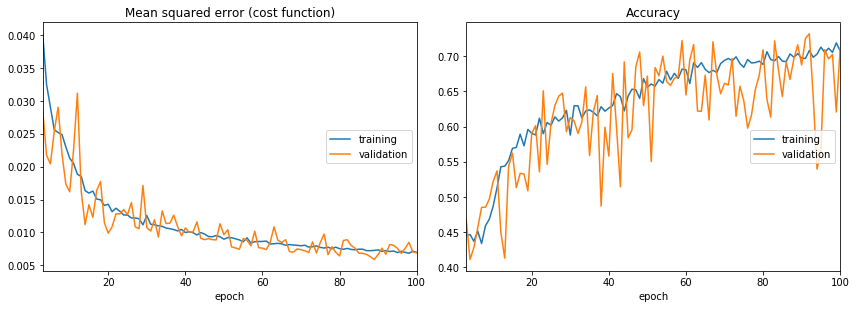

Mean squared error (cost function):
training   (min:    0.007, max:    0.078, cur:    0.007)
validation (min:    0.006, max:    0.069, cur:    0.007)

Accuracy:
training   (min:    0.413, max:    0.719, cur:    0.708)
validation (min:    0.411, max:    0.732, cur:    0.712)


In [12]:
#Compile the model and train
autoencoder2.compile(loss='mean_squared_error', optimizer = RMSprop(), metrics=['accuracy'])
autoencoder_train_2 = autoencoder2.fit(x_train, x_train, epochs=100, batch_size=64, verbose=1, validation_data=(x_val, x_val), callbacks=[PlotLossesKeras()])

(-0.5, 207.5, 207.5, -0.5)

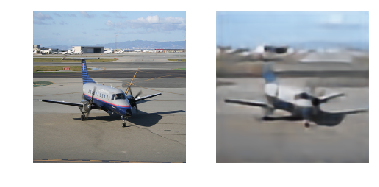

In [13]:
#autoencoder output in test set
reconstructed_images = autoencoder2.predict(x_val)

plt.subplot(121)
plt.imshow(x_val[90])
plt.axis('off')

# Display the reconstructed version of this image
plt.subplot(122)
plt.imshow(reconstructed_images[90])
plt.axis('off')

## Classifier (freeze the encoder layers): 

**First Case:**

- loss: binary_crossentropy
- activation: sigmoid
- optimizer: adam

#### The model overfitts immediately in this case

In [0]:
#Build the model
encoder_11 = Model(inputs=autoencoder2.input, outputs=autoencoder2.get_layer('conv2d_4').output)

#Freeze the encoder layers
for layer in encoder_11.layers:
    layer.trainable = False
    #Randomy initialize each parameter at start of training
    #if hasattr(layer, 'kernel_initializer'):
    #        layer.kernel_initializer = 'random_uniform'  #random_normal
    #        layer.bias_initializer = 'zeros'

encoder_output_flatten_11 = Flatten()(encoder_11.output)
dense_11 = Dense(5, activation='sigmoid')(encoder_output_flatten_11)
classifier_frozen_11 = Model(inputs=input_img, outputs=dense_11)

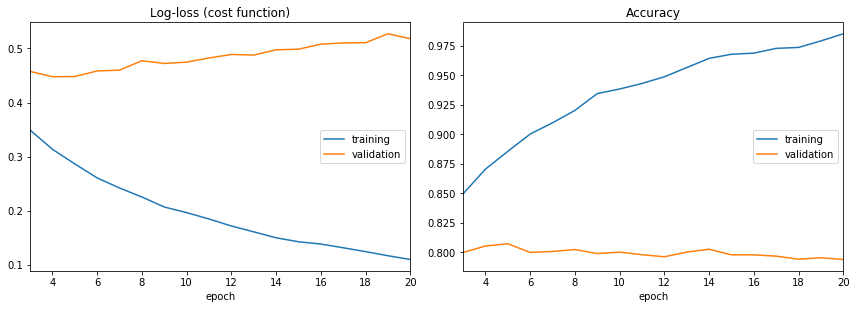

Log-loss (cost function):
training   (min:    0.110, max:    0.510, cur:    0.110)
validation (min:    0.448, max:    0.527, cur:    0.518)

Accuracy:
training   (min:    0.774, max:    0.985, cur:    0.985)
validation (min:    0.794, max:    0.807, cur:    0.794)


In [22]:
#Compile and train
classifier_frozen_11.compile(loss= "binary_crossentropy", optimizer= "adam", metrics=['accuracy'])
classifier_frozen_train_11 = classifier_frozen_11.fit(x_train, y_train, epochs=20, batch_size=64,verbose=1,validation_data=(x_val, y_val), callbacks=[PlotLossesKeras()])

In [24]:
# Model Evaluation on the Test Set
test_evaluation_11 = classifier_frozen_11.evaluate(x_val, y_val, verbose=0)
print('Test loss:', test_evaluation_11[0])
print('Test accuracy:', test_evaluation_11[1])

Test loss: 0.518080129144954
Test accuracy: 0.7938775617249157


In [0]:
# Predict Labels
predicted_classes_11 = classifier_frozen_11.predict(x_val)

#Calculate correct and incorrent classifications
correct11 = np.where(predicted_classes_11 == y_val)[0]
incorrect11 = np.where(predicted_classes_11 != y_val)[0]

print("Found %d correct labels" % len(correct11))
print("Found %d incorrect labels" % len(incorrect11))

**Second Case: Stopped earlier the training process since the validation loss function increases instead of dicreasing, being dangerous for overfitting**

- Loss: categorical_crossentropy
- Activation: Softmax
- Optimizer: Adam

In [0]:
#Build the model
encoder_8 = Model(inputs=autoencoder2.input, outputs=autoencoder2.get_layer('conv2d_4').output)

#Do not freeze the encoder layers
for layer in encoder_8.layers:
    layer.trainable = False
    #Randomy initialize each parameter at start of training
    #if hasattr(layer, 'kernel_initializer'):
    #        layer.kernel_initializer = 'random_uniform'  #random_normal
    #        layer.bias_initializer = 'zeros'

encoder_output_flatten_8 = Flatten()(encoder_8.output)
dense_8 = Dense(5, activation='softmax')(encoder_output_flatten_8)
classifier_frozen_8 = Model(inputs=input_img, outputs=dense_8)

##### The model started overfitting immidiatelly, so stopped it earlier. Stopped it manually. Keras offers the EarlyStopping function as well, which by monitoring the validation loss can stop automatically the training process to avoid overfitting.

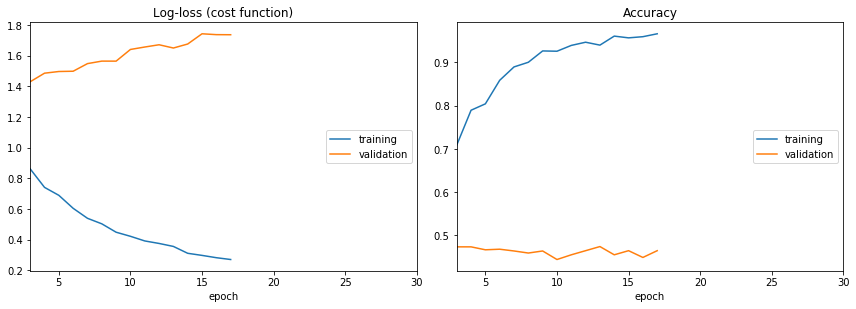

Log-loss (cost function):
training   (min:    0.270, max:    1.324, cur:    0.270)
validation (min:    1.430, max:    1.743, cur:    1.737)

Accuracy:
training   (min:    0.500, max:    0.966, cur:    0.966)
validation (min:    0.444, max:    0.474, cur:    0.465)
Epoch 18/30
 128/1489 [=>............................] - ETA: 5s - loss: 0.3096 - acc: 0.9609

KeyboardInterrupt: ignored

In [28]:
#Compile and train
classifier_frozen_8.compile(loss= "categorical_crossentropy", optimizer= "adam", metrics=['accuracy'])
classifier_frozen_train_8 = classifier_frozen_8.fit(x_train, y_train, epochs=30, batch_size=64,verbose=1,validation_data=(x_val, y_val), callbacks=[PlotLossesKeras()])

In [29]:
# Model Evaluation on the Test Set
test_evaluation_8 = classifier_frozen_8.evaluate(x_val, y_val, verbose=0)
print('Test loss:', test_evaluation_8[0])
print('Test accuracy:', test_evaluation_8[1])

Test loss: 1.7408190916995614
Test accuracy: 0.46666666672748774


## Classifier (Retrain encoder layers): 

**First Case:**

- loss: Binary cross entropy
- activation: sigmoid
- optimizer: adam

#### The model overfitts immediately in this case

In [0]:
#Build the model
encoder_9 = Model(inputs=autoencoder2.input, outputs=autoencoder2.get_layer('conv2d_4').output)

#Do not freeze the encoder layers
for layer in encoder_9.layers:
    layer.trainable = True
    #Randomy initialize each parameter at start of training
    #if hasattr(layer, 'kernel_initializer'):
    #        layer.kernel_initializer = 'random_uniform'  #random_normal
    #        layer.bias_initializer = 'zeros'

encoder_output_flatten_9 = Flatten()(encoder_9.output)
dense_9 = Dense(5, activation='sigmoid')(encoder_output_flatten_9)
classifier_non_frozen_9 = Model(inputs=input_img, outputs=dense_9)

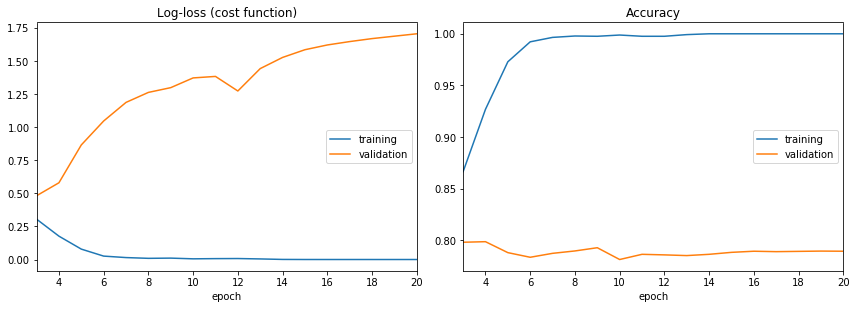

Log-loss (cost function):
training   (min:    0.000, max:    0.479, cur:    0.000)
validation (min:    0.439, max:    1.705, cur:    1.705)

Accuracy:
training   (min:    0.783, max:    1.000, cur:    1.000)
validation (min:    0.781, max:    0.799, cur:    0.789)


In [32]:
#Compile and train
classifier_non_frozen_9.compile(loss= "binary_crossentropy", optimizer= "adam", metrics=['accuracy'])
classifier_non_frozen_train_9 = classifier_non_frozen_9.fit(x_train, y_train, epochs=20, batch_size=32,verbose=1,validation_data=(x_val, y_val), callbacks=[PlotLossesKeras()])

In [33]:
# Model Evaluation on the Test Set
test_evaluation_9 = classifier_non_frozen_9.evaluate(x_val, y_val, verbose=0)
print('Test loss:', test_evaluation_9[0])
print('Test accuracy:', test_evaluation_9[1])

Test loss: 1.7045333740662556
Test accuracy: 0.7892517183102719


In [0]:
# Predict Labels
predicted_classes_9 = classifier_non_frozen_9.predict(x_val)


#Calculate correct and incorrent classifications
correct9 = np.where(predicted_classes_9 == y_val)[0]
incorrect9 = np.where(predicted_classes_9 != y_val)[0]

print("Found %d correct labels" % len(correct9))
print("Found %d incorrect labels" % len(incorrect9))

# **References:**

- https://www.datacamp.com/community/tutorials/autoencoder-classifier-python?fbclid=IwAR1rdwM1JxsryB6R9Imk-Lu72uJ_TR1W2OZOSRyd_-iZiGGYLWbeDqkOUrc
- https://keras.io/initializers/
- https://keras.io/activations/
- https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/
- https://www.dlology.com/blog/how-to-choose-last-layer-activation-and-loss-function/
- https://www.quora.com/Why-is-it-better-to-use-Softmax-function-than-sigmoid-function
- https://glassboxmedicine.com/2019/05/26/classification-sigmoid-vs-softmax/


